In [ ]:
# 필요한 라이브러리 import
import zipfile as zf
import os

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import Counter
import pandas as pd
from sklearn.metrics import accuracy_score

import time
import copy
import random
import seaborn as sns
from torch import nn, optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from multiprocessing import cpu_count
from torch.utils.data import Subset
from torchvision.transforms import ColorJitter, RandomRotation
from torch.utils.data import Dataset

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 전체 데이터셋
files = zf.ZipFile("/content/drive/MyDrive/데이터 크리에이터 캠프/데이터셋.zip",'r')
files.extractall()
files.close()

In [ ]:
# train 데이터셋
files = zf.ZipFile("/content/kfood_train.zip",'r')
files.extractall()
files.close()

In [ ]:
# validation 데이터셋
files = zf.ZipFile("/content/kfood_val.zip",'r')
files.extractall()
files.close()

### **MISSION 2.**
- Mission 1 결과 분석
- 분류 모델 성능 향상을 위한 파라미터 비교(단, 예선은 ResNet 아키텍처만 사용)
- 최종 모델의 성능 경향에 대한 분석

In [ ]:
# 데이터셋 로드
train_ds = ImageFolder('/content/train')
val_ds = ImageFolder('/content/val')

In [ ]:
# train 데이터셋을 train, validation으로 분할
random.seed(123)

train_ratio = 0.8
train_size = int(train_ratio * len(train_ds))
val_size = len(train_ds) - train_size

indices = list(range(len(train_ds)))                # 인덱스를 무작위로 섞어 무작위로 분할하도록 함
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = list(set(indices) - set(train_indices))
val_indices.sort()

train_dataset = Subset(train_ds, train_indices)
val_dataset = Subset(train_ds, val_indices)

print(len(train_dataset))
print(len(val_dataset))

26874
6719


In [ ]:
# Subset한 데이터에 이미지 변환을 적용하기 위해 사용자 정의 데이터셋 클래스 정의
class MyTransformDataset(Dataset):
    def __init__(self, dataset, transform=None):    # 클래스의 생성자, 데이터셋에 이미지 변환 적용
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# train 데이터에 대한 변환 설정 및 데이터셋 로드
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

train_dataset = MyTransformDataset(train_dataset, transform=train_transform)

In [ ]:
# validation, test 데이터에 대한 변환 설정 및 데이터셋 로드
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),                            # ResNet34의 가장 적합한 input size인 3*224*224으로 설
    transforms.ToTensor(),                                    # 딥러닝 모델은 일반적으로 텐서 형태의 데이터를 입력하므로 텐서로 변환
    transforms.Lambda(lambda x: x * 2 -1)                     # Min-Max(-1~1) 스케일링 적용
])

val_dataset = MyTransformDataset(val_dataset, transform=valtest_transform)
test_dataset = ImageFolder('/content/val', transform=valtest_transform)

In [ ]:
# 데이터 로더 설정
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)      # 검증 데이터나 테스트 데이터는 모델의 성능을 평가하는데 사용되므로 무작위성을 추가하면
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)    # 모델 성능 평가에 영향을 미칠 수 있으므로 shuffle=false로 지정

In [ ]:
# 디바이스 및 환경 설정
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # DEVICE를 GPU가 사용 가능한 경우 'cuda'로, 그렇지 않은 경우 'cpu'로 설정.
IMG_SIZE = (224, 224)                                                                 # 이미지 크기를 (224, 224)로 정의
LEARNING_RATE = 0.001                                                                 # 학습률을 0.001로 정의
NUM_CLASSES = 42                                                                      # 클래스 수를 42로 정의
NUM_EPOCHS = 100
NUM_CPU = cpu_count()                                                                 # 사용 가능한 CPU 코어 수를 가져옴.

In [ ]:
# 모델 구축
from torchvision.models import densenet121
from torch.optim.lr_scheduler import CosineAnnealingLR

model = densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(DEVICE)
params = model.parameters()                                                                                # 모델을 DEVICE로 이동

criterion = torch.nn.CrossEntropyLoss()                                                                    # 손실 함수를 CrossEntropy로, 최적화 알고리즘을 Adam으로 설정
optimizer = torch.optim.NAdam(params, lr=LEARNING_RATE, betas=(0.999, 0.999), weight_decay=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 모델 학습을 위한 함수 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())                           # 가장 높은 검증 정확도를 가진 모델 가중치를 저장하기 위한 변수로 초기값은 현재 모델의 가중치로 설정
    best_acc = 0.0                                                               # 가장 높은 검증 정확도를 저장하기 위한 변수로 초기값은 0으로 설정
    best_val_loss = float('inf')                                                 # 가장 낮은 검증 손실값을 저장하기 위한 변수로 초기값은 매우 큰 값으로 설정

    train_losses = []                                                            # 훈련 손실을 저장하기 위한 리스트
    train_accuracies = []                                                        # 훈련 정확도를 저장하기 위한 리스트
    val_losses = []                                                              # 검증 손실을 저장하기 위한 리스트
    val_accuracies = []                                                          # 검증 정확도를 저장하기 위한 리스트
    counter = 0                                                                  # early stopping을 위해 정의한 변수로 가장 높은 검증 정확도가 갱신되지 않은 epochs 횟수를 저장

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        model.train()                                                            # 모델을 학습 모드로 설정
        running_train_loss = 0.0                                                 # 현재 에포크에서의 손실을 누적하는 변수로 초기값은 0으로 설정
        running_train_corrects = 0                                               # 올바르게 분류된 샘플 수를 누적하는 변수로 초기값은 0으로 설정

        for inputs, labels in train_loader:                                      # train_loader를 순회하면서 훈련 데이터를 로드하고,
            inputs = inputs.to(DEVICE)                                           # GPU 디바이스로 데이터를 이동시켜 forward pass 및 backward pass를 수행하여 모델을 훈련
            labels = labels.to(DEVICE)
            optimizer.zero_grad()                                                # 모델의 매개변수에 대한 그래디언트(gradient)를 초기화하는 역할
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            running_train_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = running_train_corrects.double() / len(train_loader.dataset)
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_train_loss, epoch_train_acc))

        train_losses.append(epoch_train_loss)                                    # 훈련 손실 기록
        train_accuracies.append(epoch_train_acc)                                 # 훈련 정확도 기록

        model.eval()                                                             # 모델을 평가 모드로 설정
        running_val_loss = 0.0                                                   # running_loss와 running_corrects 변수를 초기화
        running_val_corrects = 0

        for inputs, labels in val_loader:                                        # val_loader를 순회하면서 검증 데이터에 대한 손실과 정확도를 계산
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()                                                # 모델의 매개변수에 대한 그래디언트(gradient)를 초기화하는 역할
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            running_val_corrects += torch.sum(preds == labels.data)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = running_val_corrects.double() / len(val_loader.dataset)
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_val_loss, epoch_val_acc))
        print('-' * 30)

        val_losses.append(epoch_val_loss)                                        # 검증 손실 기록
        val_accuracies.append(epoch_val_acc)                                     # 검증 정확도 기록

        scheduler.step()                                                         # 스케줄러의 스텝 수행

        if epoch_val_acc > best_acc:                                             # 현재 에포크의 검증 정확도가 이전 최고 정확도(best_acc)보다 높으면,
            best_acc = epoch_val_acc                                             # 최고 정확도를 업데이트하고 모델 가중치를 지정된 경로에 저장.
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, '/content/drive/MyDrive/데이터 크리에이터 캠프/본선/checkpoint/M2_densenet121_final.pth')
            counter = 0                                                          # 최고 정확도 갱신되면 다시 counter을 0으로 설정
        else:
            counter += 1                                                         # 최고 정확도가 갱신되지 않았으면 counter에 +1

        if epoch_val_loss < best_val_loss:                                       # 현재 에포크의 검증 손실 값이 이전 최저 손실 값보다 낮으면 최저 손실 값을 업데이트.
            best_val_loss = epoch_val_loss

        if counter >= patience:                                                  # counter의 값이 patience를 넘어가면, early stopping
            print("Early stopping. Training stopped.")
            break

    print('Best Validation Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)                                        # 최고 모델 가중치를 모델에 로드하고, 이 모델을 반환
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# 모델 학습 (5 epochs 이상 동안 최고 정확도 갱신 안 되면 early syopping)
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, scheduler, NUM_EPOCHS, train_loader, val_loader, patience=5)

Epoch 1/100
Train Loss: 3.1232 Train Acc: 0.1606


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Val Loss: 2.8811 Val Acc: 0.2110
------------------------------
Epoch 2/100
Train Loss: 2.7157 Train Acc: 0.2472
Val Loss: 2.6308 Val Acc: 0.2593
------------------------------
Epoch 3/100
Train Loss: 2.4468 Train Acc: 0.3113
Val Loss: 2.4315 Val Acc: 0.3198
------------------------------
Epoch 4/100
Train Loss: 2.2130 Train Acc: 0.3624
Val Loss: 2.2797 Val Acc: 0.3419
------------------------------
Epoch 5/100
Train Loss: 2.0412 Train Acc: 0.4102
Val Loss: 2.1096 Val Acc: 0.3837
------------------------------
Epoch 6/100
Train Loss: 1.8691 Train Acc: 0.4553
Val Loss: 1.8188 Val Acc: 0.4666
------------------------------
Epoch 7/100
Train Loss: 1.7173 Train Acc: 0.5000
Val Loss: 1.6038 Val Acc: 0.5248
------------------------------
Epoch 8/100
Train Loss: 1.5713 Train Acc: 0.5405
Val Loss: 1.4632 Val Acc: 0.5584
------------------------------
Epoch 9/100
Train Loss: 1.4648 Train Acc: 0.5714
Val Loss: 1.5287 Val Acc: 0.5465
------------------------------
Epoch 10/100
Train Loss: 1.3575 

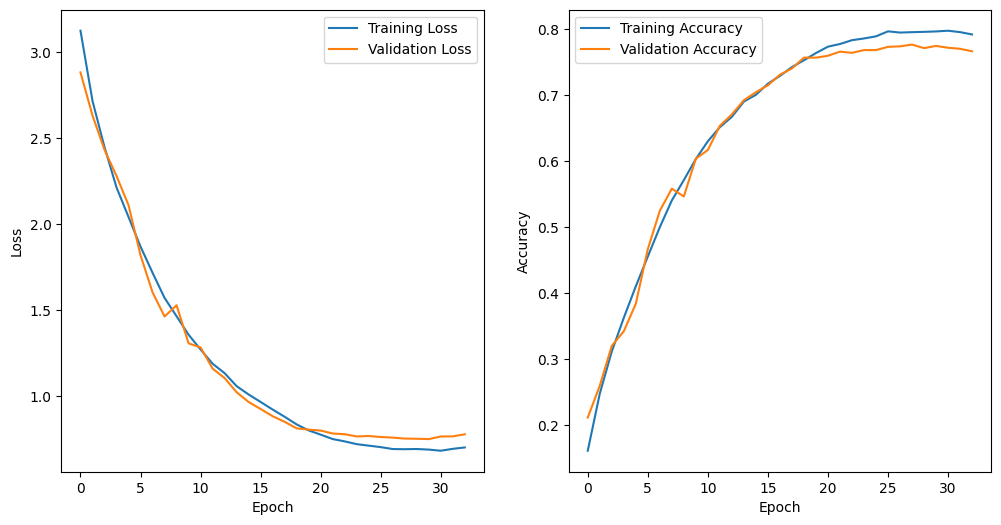

In [ ]:
# accuracy, loss 그래프 출력하는 함수 정의
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))                                  # loss 그래프 출력
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)                                        # accuracy 그래프 출력
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

train_accuracies = [acc.to('cpu').item() for acc in train_accuracies]
val_accuracies = [acc.to('cpu').item() for acc in val_accuracies]

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# best model 불러오기
from torchvision.models import densenet121

model = densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
checkpoint = torch.load('/content/drive/MyDrive/데이터 크리에이터 캠프/본선/checkpoint/M2_densenet121_final.pth',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)                                                # 체크포인트 불러오기
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Validation accuracy 측정 함수 정의 (제공된 코드 사용)
@torch.no_grad()
def validate_epoch(model, data_loader, device):
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.cat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
# 테스트 데이터에 대한 정확도 측정
test_accuracy = validate_epoch(model, test_loader, DEVICE)
print(f'\ntest Accuracy: {test_accuracy:.2f}%')

measuring accuracy: 100%|██████████| 66/66 [00:37<00:00,  1.75it/s]


test Accuracy: 77.30%


In [ ]:
# 데이터 로더 설정
BATCH_SIZE = 16
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)    # 모델 성능 평가에 영향을 미칠 수 있으므로 shuffle=false로 지정

In [ ]:
# 테스트 데이터에 대한 정확도 측정
test_accuracy = validate_epoch(model, test_loader, DEVICE)
print(f'\ntest Accuracy: {test_accuracy:.2f}%')

measuring accuracy: 100%|██████████| 263/263 [00:35<00:00,  7.36it/s]


test Accuracy: 77.30%


In [ ]:
# 혼동행렬 출력 함수 정의
def plot_confusion_matrix(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in tqdm(data_loader, total=len(data_loader), desc='Creating Confusion Matrix'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Creating Confusion Matrix: 100%|██████████| 263/263 [00:43<00:00,  6.00it/s]


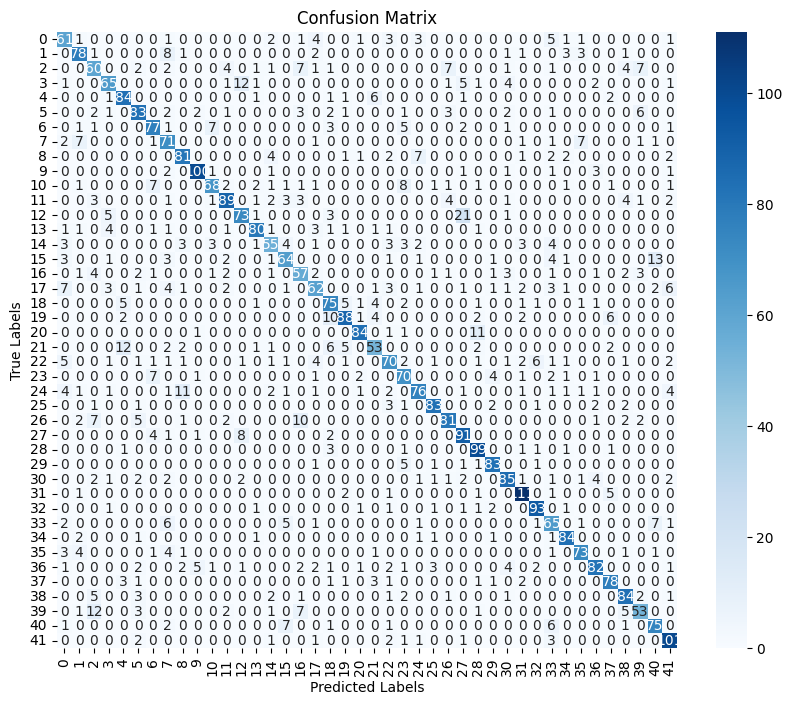

In [ ]:
# 혼동행렬 출력
plot_confusion_matrix(model, test_loader, DEVICE)

In [ ]:
from sklearn.metrics import classification_report

model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68        85
           1       0.77      0.79      0.78        99
           2       0.61      0.61      0.61        99
           3       0.77      0.69      0.73        94
           4       0.79      0.87      0.82        97
           5       0.76      0.75      0.76       110
           6       0.77      0.78      0.77        99
           7       0.62      0.76      0.68        93
           8       0.78      0.79      0.78       103
           9       0.91      0.90      0.90       111
          10       0.83      0.69      0.76        98
          11       0.82      0.77      0.80       115
          12       0.75      0.70      0.73       104
          13       0.87      0.82      0.84        98
          14       0.71      0.65      0.68        85
          15       0.74      0.67      0.70        95
          16       0.62      0.68      0.65        84
          17       0.70    

In [21]:
report = classification_report(true_labels, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.648936,0.717647,0.681564,85.000000
1,0.772277,0.787879,0.780000,99.000000
2,0.612245,0.606061,0.609137,99.000000
3,0.773810,0.691489,0.730337,94.000000
4,0.785047,0.865979,0.823529,97.000000
5,0.761468,0.754545,0.757991,110.000000
6,0.770000,0.777778,0.773869,99.000000
7,0.617391,0.763441,0.682692,93.000000
8,0.778846,0.786408,0.782609,103.000000
9,0.909091,0.900901,0.904977,111.000000


In [41]:
import cv2
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Assuming you have already loaded the image using cv2.imread
image_path = "/content/train/시래기국/Img_019_0000.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Now, you can use `input_tensor` as input to your model

# Specify the target layer
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

# Apply GradCAM
with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Apply GradCAM++
with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

In [46]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/시래기국/Img_019_0000.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

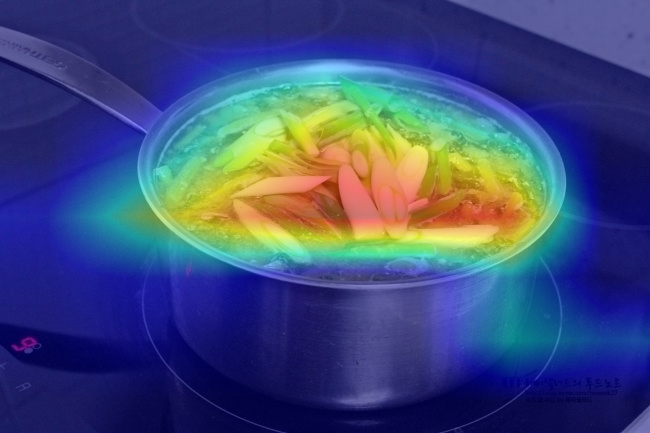

In [47]:
Image.fromarray(visualization)

In [48]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/떡갈비/Img_006_0000.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

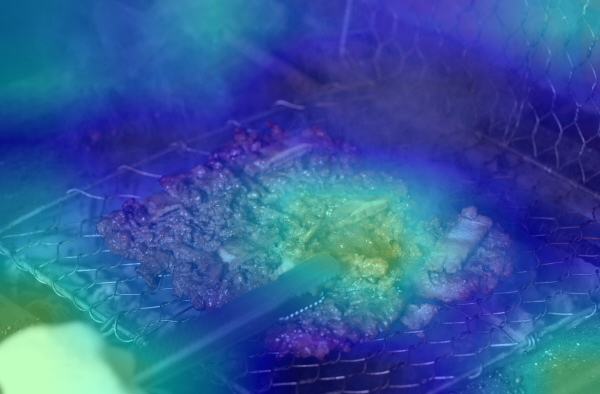

In [49]:
Image.fromarray(visualization)

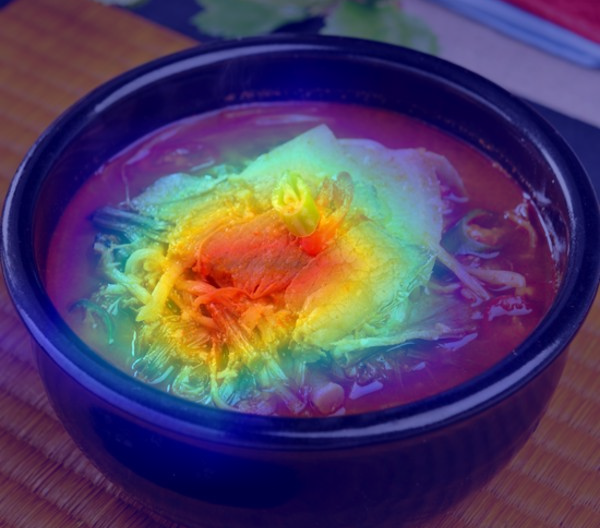

In [51]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/육개장/Img_020_0001.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

Image.fromarray(visualization)

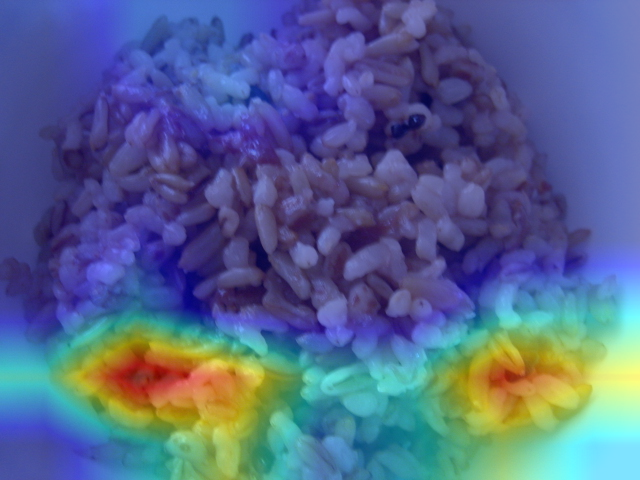

In [52]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/잡곡밥/Img_076_0000.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

Image.fromarray(visualization)

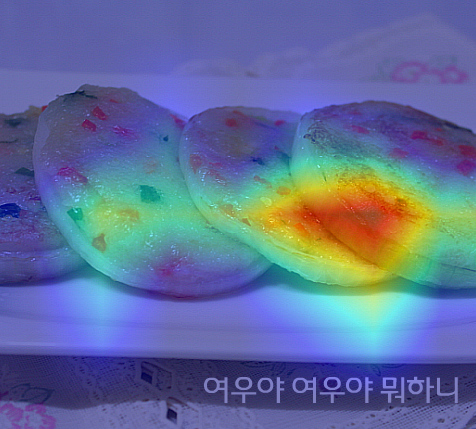

In [54]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/감자전/Img_097_0001.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

Image.fromarray(visualization)

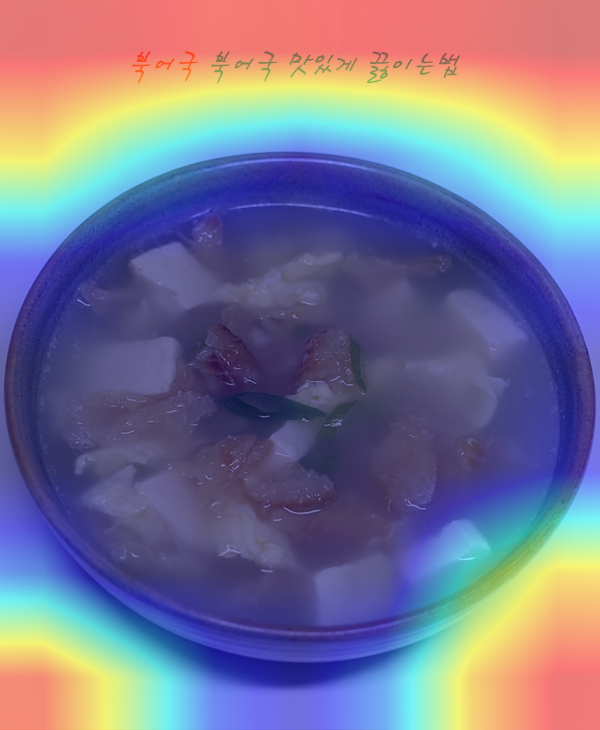

In [55]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

# Load the image
image_path = "/content/train/북엇국/Img_018_0000.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Assuming the model expects RGB images

# Convert NumPy array to PIL Image
pil_image = Image.fromarray(image)

# Define the transformation
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

# Apply the transformation
input_tensor = valtest_transform(pil_image)
input_tensor = Variable(input_tensor.unsqueeze(0))  # Add batch dimension (assuming your model expects batches)

# Perform GradCAM and GradCAM++ computations (as in your previous code)
target_layer = model.features.denseblock4.denselayer16
target_layers = [target_layer]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as camplus:
    grayscale_camplus = camplus(input_tensor=input_tensor, aug_smooth=True, eigen_smooth=True)

# Normalize the image to the range [0, 1]
normalized_image = image.astype(np.float32) / 255.0

# Resize the heatmap to match the shape of the image
resized_heatmap = cv2.resize(grayscale_cam[0], (normalized_image.shape[1], normalized_image.shape[0]))

# Visualize the results
# Assuming your visualization function is show_cam_on_image
visualization = show_cam_on_image(normalized_image, resized_heatmap, use_rgb=True)

Image.fromarray(visualization)